# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

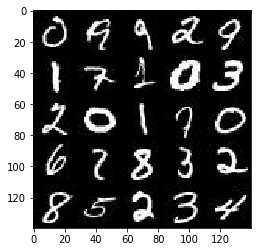

In [38]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

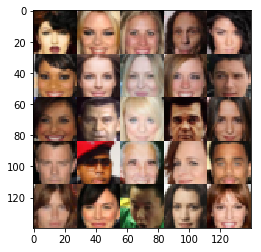

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [44]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, *(image_width, image_height, image_channels)), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [73]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28, 28, 3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x512
        
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [72]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 7x7x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x64
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [55]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake))
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [56]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [57]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [68]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    samples, losses = [], []
    steps = 0
    
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 1, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5778... Generator Loss: 2.6846
Epoch 1/2... Discriminator Loss: 3.8040... Generator Loss: 12.5592
Epoch 1/2... Discriminator Loss: 0.4228... Generator Loss: 5.1153
Epoch 1/2... Discriminator Loss: 2.5859... Generator Loss: 10.6365
Epoch 1/2... Discriminator Loss: 0.7870... Generator Loss: 1.0588
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.4895
Epoch 1/2... Discriminator Loss: 0.4861... Generator Loss: 2.4938
Epoch 1/2... Discriminator Loss: 1.7270... Generator Loss: 3.5008
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 1.0365
Epoch 1/2... Discriminator Loss: 0.5852... Generator Loss: 2.9287


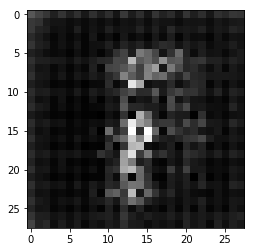

Epoch 1/2... Discriminator Loss: 0.5433... Generator Loss: 1.7816
Epoch 1/2... Discriminator Loss: 0.5079... Generator Loss: 2.5692
Epoch 1/2... Discriminator Loss: 0.4790... Generator Loss: 2.5126
Epoch 1/2... Discriminator Loss: 0.4281... Generator Loss: 2.5261
Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 3.7301
Epoch 1/2... Discriminator Loss: 3.3181... Generator Loss: 0.0606
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 5.3894
Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 5.0209
Epoch 1/2... Discriminator Loss: 0.6333... Generator Loss: 1.8938
Epoch 1/2... Discriminator Loss: 0.6207... Generator Loss: 2.6595


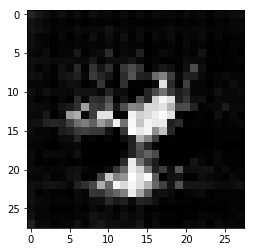

Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 3.4132
Epoch 1/2... Discriminator Loss: 1.0263... Generator Loss: 2.6312
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.8933
Epoch 1/2... Discriminator Loss: 0.7516... Generator Loss: 5.4013
Epoch 1/2... Discriminator Loss: 0.7584... Generator Loss: 2.1104
Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 5.4471
Epoch 1/2... Discriminator Loss: 0.8441... Generator Loss: 2.7297
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.5774
Epoch 1/2... Discriminator Loss: 0.7733... Generator Loss: 4.7790
Epoch 1/2... Discriminator Loss: 0.5963... Generator Loss: 1.7810


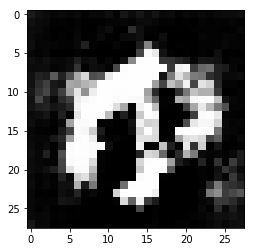

Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 5.5253
Epoch 1/2... Discriminator Loss: 0.4612... Generator Loss: 3.9349
Epoch 1/2... Discriminator Loss: 0.5533... Generator Loss: 2.4740
Epoch 1/2... Discriminator Loss: 1.0029... Generator Loss: 4.5807
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.2254
Epoch 1/2... Discriminator Loss: 0.8440... Generator Loss: 1.1189
Epoch 1/2... Discriminator Loss: 0.6189... Generator Loss: 2.4467
Epoch 1/2... Discriminator Loss: 0.5333... Generator Loss: 1.8833
Epoch 1/2... Discriminator Loss: 0.8916... Generator Loss: 4.3246
Epoch 1/2... Discriminator Loss: 0.4333... Generator Loss: 2.8253


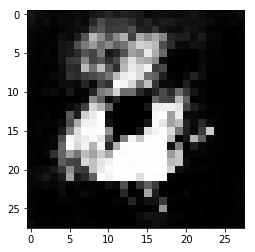

Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 7.9460
Epoch 1/2... Discriminator Loss: 0.5905... Generator Loss: 2.5186
Epoch 1/2... Discriminator Loss: 0.9211... Generator Loss: 2.1469
Epoch 1/2... Discriminator Loss: 2.7731... Generator Loss: 6.6263
Epoch 1/2... Discriminator Loss: 0.5567... Generator Loss: 2.7363
Epoch 1/2... Discriminator Loss: 1.3804... Generator Loss: 5.9531
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 4.4464
Epoch 1/2... Discriminator Loss: 0.6626... Generator Loss: 2.8664
Epoch 1/2... Discriminator Loss: 0.4882... Generator Loss: 2.8947
Epoch 1/2... Discriminator Loss: 0.5145... Generator Loss: 2.3400


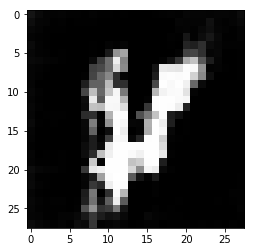

Epoch 1/2... Discriminator Loss: 0.5721... Generator Loss: 2.8974
Epoch 1/2... Discriminator Loss: 0.5609... Generator Loss: 2.0740
Epoch 1/2... Discriminator Loss: 0.5712... Generator Loss: 1.7179
Epoch 1/2... Discriminator Loss: 0.6548... Generator Loss: 1.6104
Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 1.5184
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 3.7647
Epoch 1/2... Discriminator Loss: 2.1789... Generator Loss: 8.9475
Epoch 1/2... Discriminator Loss: 0.6398... Generator Loss: 1.5156
Epoch 1/2... Discriminator Loss: 0.7014... Generator Loss: 2.1092
Epoch 1/2... Discriminator Loss: 0.5671... Generator Loss: 1.8016


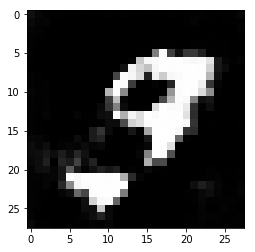

Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 4.4771
Epoch 1/2... Discriminator Loss: 0.9408... Generator Loss: 1.1123
Epoch 1/2... Discriminator Loss: 1.0642... Generator Loss: 3.5557
Epoch 1/2... Discriminator Loss: 0.7525... Generator Loss: 1.2327
Epoch 1/2... Discriminator Loss: 0.8657... Generator Loss: 3.1504
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.6524
Epoch 1/2... Discriminator Loss: 1.5640... Generator Loss: 6.4292
Epoch 1/2... Discriminator Loss: 1.5244... Generator Loss: 0.4574
Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 1.8051
Epoch 1/2... Discriminator Loss: 0.6148... Generator Loss: 2.5513


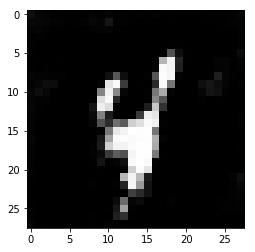

Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 1.1056
Epoch 1/2... Discriminator Loss: 1.1223... Generator Loss: 1.2035
Epoch 1/2... Discriminator Loss: 0.6942... Generator Loss: 2.6838
Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 1.0566... Generator Loss: 0.9950
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 3.8352
Epoch 1/2... Discriminator Loss: 1.4622... Generator Loss: 4.7558
Epoch 1/2... Discriminator Loss: 0.7338... Generator Loss: 1.3317
Epoch 1/2... Discriminator Loss: 2.3854... Generator Loss: 6.5971


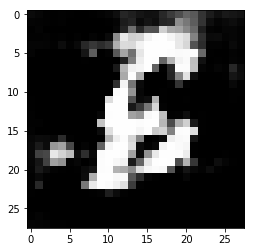

Epoch 1/2... Discriminator Loss: 0.7102... Generator Loss: 2.8458
Epoch 1/2... Discriminator Loss: 1.4779... Generator Loss: 5.0262
Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 2.7012
Epoch 1/2... Discriminator Loss: 0.5939... Generator Loss: 2.1388
Epoch 1/2... Discriminator Loss: 0.5287... Generator Loss: 2.8886
Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 1.0289
Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 0.8477
Epoch 1/2... Discriminator Loss: 2.1010... Generator Loss: 5.8516
Epoch 1/2... Discriminator Loss: 0.7594... Generator Loss: 1.5872
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 0.8296


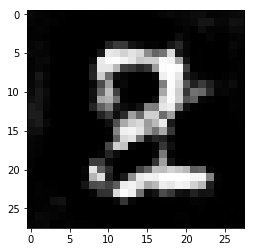

Epoch 1/2... Discriminator Loss: 0.5880... Generator Loss: 2.2099
Epoch 1/2... Discriminator Loss: 0.7890... Generator Loss: 1.1226
Epoch 1/2... Discriminator Loss: 0.9550... Generator Loss: 0.8636
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 1.8916
Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 2.1911
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 0.9035
Epoch 2/2... Discriminator Loss: 1.0699... Generator Loss: 3.0630
Epoch 2/2... Discriminator Loss: 0.7869... Generator Loss: 1.3619
Epoch 2/2... Discriminator Loss: 0.9586... Generator Loss: 2.2044
Epoch 2/2... Discriminator Loss: 0.9717... Generator Loss: 1.3555


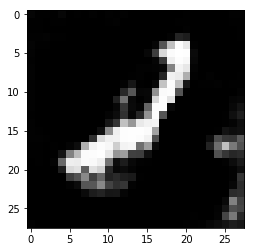

Epoch 2/2... Discriminator Loss: 2.5684... Generator Loss: 3.8487
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.6120... Generator Loss: 0.3813
Epoch 2/2... Discriminator Loss: 1.0861... Generator Loss: 1.9153
Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 1.4231
Epoch 2/2... Discriminator Loss: 1.0583... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 0.7320... Generator Loss: 1.3544
Epoch 2/2... Discriminator Loss: 1.5396... Generator Loss: 0.4700
Epoch 2/2... Discriminator Loss: 1.3502... Generator Loss: 0.5245


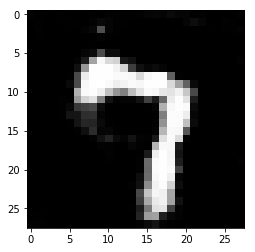

Epoch 2/2... Discriminator Loss: 1.2351... Generator Loss: 0.5891
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 1.1274... Generator Loss: 2.1461
Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 1.2073
Epoch 2/2... Discriminator Loss: 1.7092... Generator Loss: 0.4227
Epoch 2/2... Discriminator Loss: 0.8920... Generator Loss: 1.0797
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 3.1040
Epoch 2/2... Discriminator Loss: 0.8610... Generator Loss: 1.0633
Epoch 2/2... Discriminator Loss: 2.3354... Generator Loss: 0.1794
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 0.9020


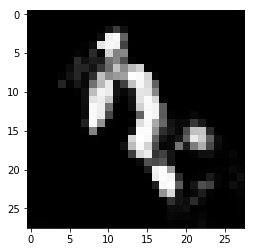

Epoch 2/2... Discriminator Loss: 0.9844... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.4776
Epoch 2/2... Discriminator Loss: 1.0314... Generator Loss: 0.8767
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 1.8667
Epoch 2/2... Discriminator Loss: 2.9443... Generator Loss: 3.9860
Epoch 2/2... Discriminator Loss: 1.0136... Generator Loss: 1.3404
Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 2.8247
Epoch 2/2... Discriminator Loss: 1.0715... Generator Loss: 0.8272
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 2.1338
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 2.6977


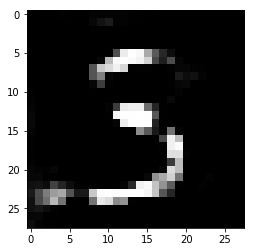

Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.6013
Epoch 2/2... Discriminator Loss: 1.0194... Generator Loss: 0.8470
Epoch 2/2... Discriminator Loss: 1.5730... Generator Loss: 0.3954
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.5729
Epoch 2/2... Discriminator Loss: 1.4782... Generator Loss: 0.5458
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 1.0141
Epoch 2/2... Discriminator Loss: 0.9488... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.6098
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.5179
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 1.1885


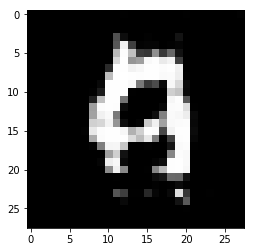

Epoch 2/2... Discriminator Loss: 0.7965... Generator Loss: 1.1174
Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 2.7100
Epoch 2/2... Discriminator Loss: 0.7981... Generator Loss: 1.3732
Epoch 2/2... Discriminator Loss: 4.6960... Generator Loss: 7.3152
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 0.4978
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 0.9632
Epoch 2/2... Discriminator Loss: 1.4896... Generator Loss: 0.4287
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.9830... Generator Loss: 0.3007
Epoch 2/2... Discriminator Loss: 1.0331... Generator Loss: 0.9118


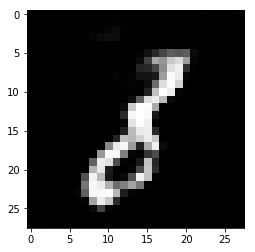

Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.5229
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 0.9134
Epoch 2/2... Discriminator Loss: 0.7478... Generator Loss: 1.6485
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 0.9996
Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.6486
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 1.0989
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 0.8922
Epoch 2/2... Discriminator Loss: 0.8655... Generator Loss: 1.0162
Epoch 2/2... Discriminator Loss: 1.6291... Generator Loss: 0.5104
Epoch 2/2... Discriminator Loss: 0.8973... Generator Loss: 1.0146


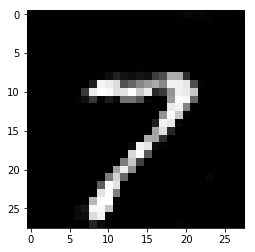

Epoch 2/2... Discriminator Loss: 1.1065... Generator Loss: 0.8265
Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 1.0322
Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.3181
Epoch 2/2... Discriminator Loss: 1.6102... Generator Loss: 4.4711
Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.6018
Epoch 2/2... Discriminator Loss: 1.1116... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 0.6138... Generator Loss: 1.8197
Epoch 2/2... Discriminator Loss: 1.3121... Generator Loss: 0.6489
Epoch 2/2... Discriminator Loss: 0.9631... Generator Loss: 1.9287


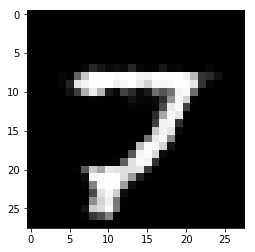

Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 0.9963
Epoch 2/2... Discriminator Loss: 1.1171... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 2.4199
Epoch 2/2... Discriminator Loss: 0.9499... Generator Loss: 0.8744
Epoch 2/2... Discriminator Loss: 0.5179... Generator Loss: 2.1175
Epoch 2/2... Discriminator Loss: 0.7341... Generator Loss: 1.5962
Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 1.1783
Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 1.3796
Epoch 2/2... Discriminator Loss: 0.7555... Generator Loss: 1.3364
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 1.0744


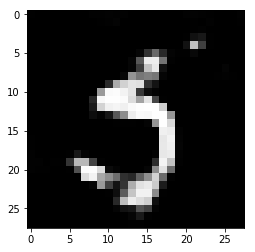

Epoch 2/2... Discriminator Loss: 1.1954... Generator Loss: 0.8530
Epoch 2/2... Discriminator Loss: 0.9285... Generator Loss: 0.9275
Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 1.0019
Epoch 2/2... Discriminator Loss: 0.7660... Generator Loss: 2.4362
Epoch 2/2... Discriminator Loss: 0.6603... Generator Loss: 1.6684
Epoch 2/2... Discriminator Loss: 0.8621... Generator Loss: 2.1525
Epoch 2/2... Discriminator Loss: 1.8353... Generator Loss: 0.3571


In [70]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8174... Generator Loss: 9.9627
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 11.0735
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 7.2718
Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 2.5127
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 3.6396
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.0242... Generator Loss: 3.6503
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 1.3176
Epoch 1/1... Discriminator Loss: 0.5411... Generator Loss: 2.2435


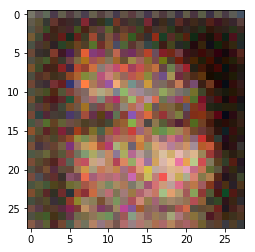

Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 4.0614
Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 2.7505
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.3959
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 2.3636
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 3.2869
Epoch 1/1... Discriminator Loss: 0.6082... Generator Loss: 2.3032
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 2.5865
Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 1.8443


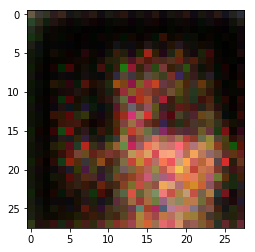

Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 3.9806
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 2.1734
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 2.1428
Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 2.2836
Epoch 1/1... Discriminator Loss: 0.5729... Generator Loss: 3.2637
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 1.5246
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 1.2997
Epoch 1/1... Discriminator Loss: 0.4657... Generator Loss: 2.8712
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 3.2636


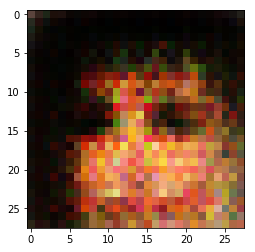

Epoch 1/1... Discriminator Loss: 0.7012... Generator Loss: 2.5579
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 1.2588
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.4961
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 2.9344
Epoch 1/1... Discriminator Loss: 0.7046... Generator Loss: 2.3079
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 1.9621
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 0.5525... Generator Loss: 2.3930
Epoch 1/1... Discriminator Loss: 0.8011... Generator Loss: 1.2274
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.8371


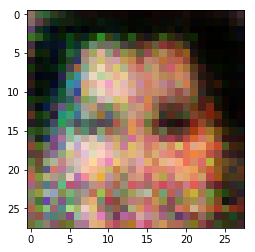

Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 2.1110
Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 1.8039
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 1.3420
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 2.3087
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.5712
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.5584
Epoch 1/1... Discriminator Loss: 1.6763... Generator Loss: 0.9635


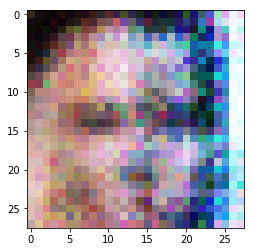

Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 2.1982
Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 2.8491
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 0.7549... Generator Loss: 1.9550
Epoch 1/1... Discriminator Loss: 0.8284... Generator Loss: 1.4052
Epoch 1/1... Discriminator Loss: 0.5555... Generator Loss: 2.4561
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.3449
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.5754


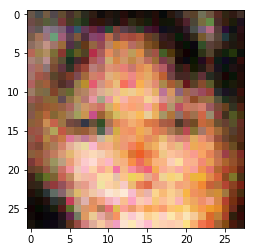

Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 2.3869
Epoch 1/1... Discriminator Loss: 0.6880... Generator Loss: 1.7599
Epoch 1/1... Discriminator Loss: 0.7843... Generator Loss: 2.1186
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.4620
Epoch 1/1... Discriminator Loss: 1.8863... Generator Loss: 0.3436
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 1.3545
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 2.3671
Epoch 1/1... Discriminator Loss: 0.7483... Generator Loss: 2.6354
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 2.8251


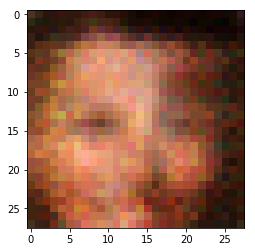

Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.5598
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 1.4199
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 3.5488
Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 1.6250
Epoch 1/1... Discriminator Loss: 0.7144... Generator Loss: 2.2000
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 1.4622
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.4304
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 1.4131


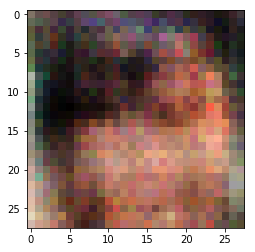

Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 3.3593
Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 1.5373
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 1.3490
Epoch 1/1... Discriminator Loss: 0.6202... Generator Loss: 1.7633
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 2.6165
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 3.1356
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 2.2239
Epoch 1/1... Discriminator Loss: 0.6617... Generator Loss: 1.7869


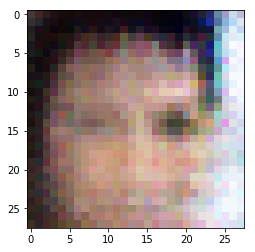

Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 1.2725
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 2.6613
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.0074
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 2.6865
Epoch 1/1... Discriminator Loss: 0.7985... Generator Loss: 1.2733
Epoch 1/1... Discriminator Loss: 0.5281... Generator Loss: 2.8087
Epoch 1/1... Discriminator Loss: 0.6419... Generator Loss: 1.7016
Epoch 1/1... Discriminator Loss: 0.7087... Generator Loss: 1.3580
Epoch 1/1... Discriminator Loss: 0.6184... Generator Loss: 1.8557


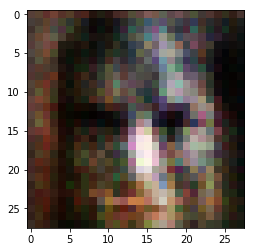

Epoch 1/1... Discriminator Loss: 1.8051... Generator Loss: 5.3590
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 3.2734
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 3.9783
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 2.8330
Epoch 1/1... Discriminator Loss: 0.8223... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 2.5062
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 2.5092
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 2.1025


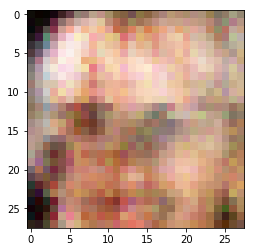

Epoch 1/1... Discriminator Loss: 0.7878... Generator Loss: 1.2613
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 0.7202... Generator Loss: 1.4553
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.6660
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 2.1814
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.5186
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 1.7698
Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 2.2170
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.9715
Epoch 1/1... Discriminator Loss: 0.5406... Generator Loss: 2.3207


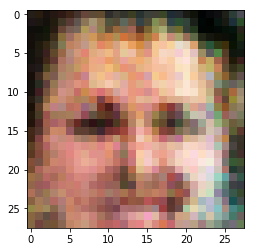

Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 0.5675... Generator Loss: 2.1202
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.2966
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.6107
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 1.4862
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 2.1909
Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 1.6281
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.6162


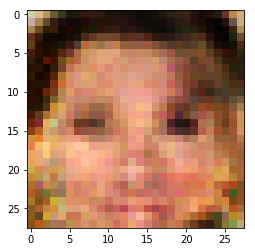

Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 1.7368
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.8862
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 5.4566
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 1.6600
Epoch 1/1... Discriminator Loss: 0.6719... Generator Loss: 1.9577
Epoch 1/1... Discriminator Loss: 0.6517... Generator Loss: 1.5887
Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 2.5211
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 1.6753
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 3.4529
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 1.2067


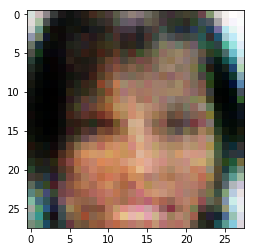

Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.6536
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 2.2521
Epoch 1/1... Discriminator Loss: 0.4833... Generator Loss: 3.1474
Epoch 1/1... Discriminator Loss: 0.6153... Generator Loss: 1.9084
Epoch 1/1... Discriminator Loss: 0.6115... Generator Loss: 2.0393
Epoch 1/1... Discriminator Loss: 0.6301... Generator Loss: 1.8687
Epoch 1/1... Discriminator Loss: 0.6826... Generator Loss: 1.6362
Epoch 1/1... Discriminator Loss: 0.6095... Generator Loss: 1.8974
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 1.9635
Epoch 1/1... Discriminator Loss: 0.6244... Generator Loss: 1.7589


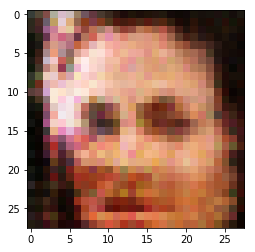

Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 2.4897
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 2.1084
Epoch 1/1... Discriminator Loss: 1.0253... Generator Loss: 3.9688
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 0.6803... Generator Loss: 1.5405
Epoch 1/1... Discriminator Loss: 0.6499... Generator Loss: 2.1216
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.6458
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 0.8685... Generator Loss: 1.1500
Epoch 1/1... Discriminator Loss: 0.6399... Generator Loss: 1.6327


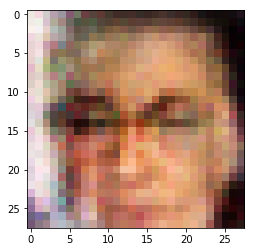

Epoch 1/1... Discriminator Loss: 0.5581... Generator Loss: 2.4758
Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 1.6367
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 2.8966
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 5.2321
Epoch 1/1... Discriminator Loss: 0.7253... Generator Loss: 1.3876
Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 1.3138
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 1.8727
Epoch 1/1... Discriminator Loss: 0.8699... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 0.6811... Generator Loss: 3.0516
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 1.4911


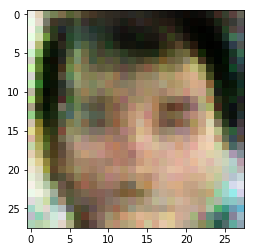

Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 0.6295... Generator Loss: 1.9338
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 1.8878
Epoch 1/1... Discriminator Loss: 0.6315... Generator Loss: 2.2402
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 0.7974... Generator Loss: 1.2901
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.4783
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 1.2210


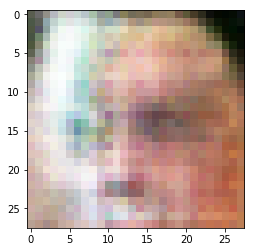

Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 4.3329
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 1.5997
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 1.3170
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.8347
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.4287
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.4545
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.3849
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.4951
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.2393


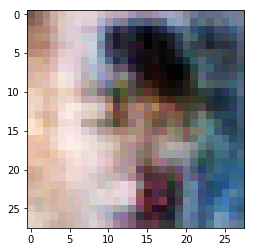

Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.7168
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 1.5874
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 3.3470
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 1.6234
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 3.1301
Epoch 1/1... Discriminator Loss: 0.6923... Generator Loss: 1.6985
Epoch 1/1... Discriminator Loss: 0.6982... Generator Loss: 2.4618


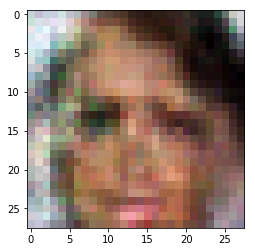

Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 4.2593
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.4745
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.1981
Epoch 1/1... Discriminator Loss: 0.5491... Generator Loss: 2.5199
Epoch 1/1... Discriminator Loss: 0.5948... Generator Loss: 1.8431
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 2.4472
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.7410
Epoch 1/1... Discriminator Loss: 0.6008... Generator Loss: 2.0173
Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 2.6284
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 3.8812


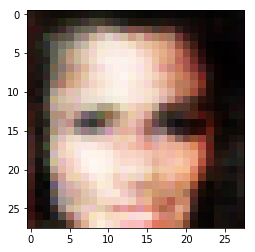

Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 1.9589
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 2.2087
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 3.0644
Epoch 1/1... Discriminator Loss: 0.7365... Generator Loss: 1.3543
Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 1.7648
Epoch 1/1... Discriminator Loss: 0.5909... Generator Loss: 1.9390
Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 1.8417
Epoch 1/1... Discriminator Loss: 0.7054... Generator Loss: 1.3405
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.2954
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 4.0609


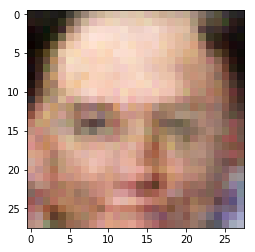

Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.2436
Epoch 1/1... Discriminator Loss: 0.6430... Generator Loss: 1.6175
Epoch 1/1... Discriminator Loss: 0.7207... Generator Loss: 1.3695
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 2.0029
Epoch 1/1... Discriminator Loss: 0.7476... Generator Loss: 2.2035
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 1.7188
Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 1.7585
Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 1.5777
Epoch 1/1... Discriminator Loss: 0.5235... Generator Loss: 2.4178


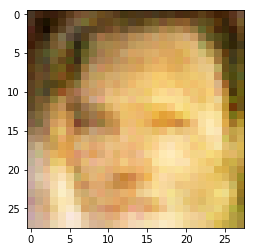

Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 1.3939
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.4140
Epoch 1/1... Discriminator Loss: 0.7996... Generator Loss: 2.9011
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 2.3233
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 1.2813
Epoch 1/1... Discriminator Loss: 0.6958... Generator Loss: 2.4481
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 3.3801
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 2.6149
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 3.8494
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 1.6219


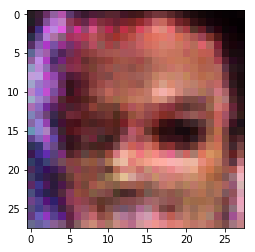

Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 1.7374
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.8704
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 2.0425
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 1.4651
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 3.9436
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 1.8343
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 1.6386
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 2.0365


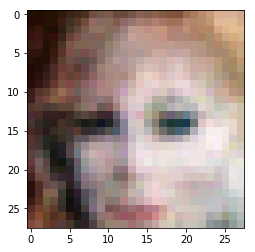

Epoch 1/1... Discriminator Loss: 0.7196... Generator Loss: 1.5351
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 2.7337
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.4158
Epoch 1/1... Discriminator Loss: 0.7266... Generator Loss: 1.7282
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 2.0918
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 1.5413
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 3.2286


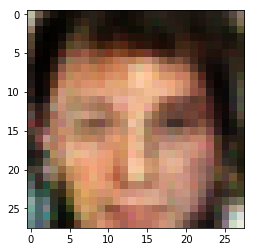

Epoch 1/1... Discriminator Loss: 0.5744... Generator Loss: 2.1345
Epoch 1/1... Discriminator Loss: 0.6037... Generator Loss: 2.3015
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 2.4858
Epoch 1/1... Discriminator Loss: 0.6572... Generator Loss: 2.3836
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.4119
Epoch 1/1... Discriminator Loss: 0.6159... Generator Loss: 2.9750
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.7366
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.9918
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 2.2622


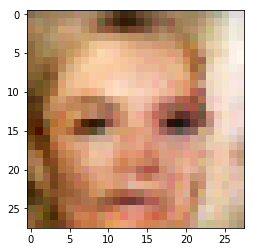

Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 0.5700... Generator Loss: 1.9068
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 3.2448
Epoch 1/1... Discriminator Loss: 0.7359... Generator Loss: 1.2990
Epoch 1/1... Discriminator Loss: 0.6339... Generator Loss: 1.8691
Epoch 1/1... Discriminator Loss: 0.7506... Generator Loss: 1.2910
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.6531
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 0.5530... Generator Loss: 2.1429
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.2698


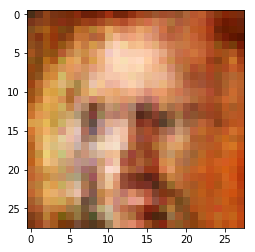

Epoch 1/1... Discriminator Loss: 0.5707... Generator Loss: 2.5918
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 1.8891
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 2.8362
Epoch 1/1... Discriminator Loss: 0.5354... Generator Loss: 2.1648
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 1.8308
Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 2.4509
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 4.0283
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.8250
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.0818


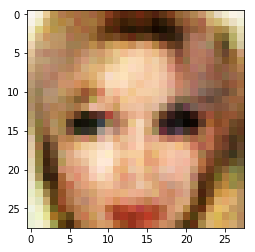

Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 1.6787
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 1.6910
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 1.5734
Epoch 1/1... Discriminator Loss: 0.5502... Generator Loss: 1.9976
Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 1.8035
Epoch 1/1... Discriminator Loss: 1.0068... Generator Loss: 3.5067
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 1.5120
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 2.5851
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.8483


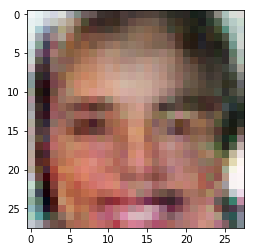

Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 2.3542
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 1.8872
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 1.5077
Epoch 1/1... Discriminator Loss: 0.6025... Generator Loss: 2.2494
Epoch 1/1... Discriminator Loss: 0.5251... Generator Loss: 2.1318
Epoch 1/1... Discriminator Loss: 0.5952... Generator Loss: 2.9298
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 0.6192... Generator Loss: 2.0432


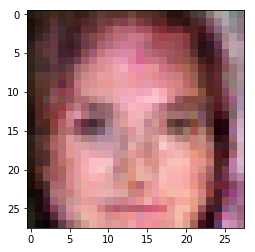

Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 2.0212
Epoch 1/1... Discriminator Loss: 0.5115... Generator Loss: 2.2590
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.7072
Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 1.5596
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 1.7035
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 1.7365


In [74]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.